Final score (RMSE): 0.9788805688469275
     ground_truth  predicted
0               5   4.234299
1               5   4.730857
2               4   4.474534
3               5   4.320182
4               4   4.304997
..            ...        ...
995             3   2.955945
996             3   3.953936
997             4   3.969273
998             4   4.068656
999             4   3.538963

[1000 rows x 2 columns]


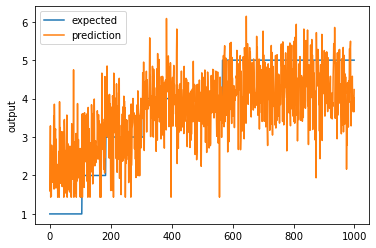

In [179]:
from importlib.machinery import SourceFileLoader
helpers = SourceFileLoader("helpers", "./helpers.py").load_module()
import os
import numpy as np
import pandas as pd
from sklearn import metrics
import sklearn.feature_extraction.text as sk_text
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

business_data_frame = pd.read_json('./dataset/business.json', lines=True)


# Removing all businesses with less then 20 reviews because of project requirements
filtered_business_data_frame = business_data_frame[business_data_frame['review_count'] >= 20]

review_data_frame = pd.read_json('./dataset/reviews.json', lines=True, nrows=5000)

review_data_frame.drop('user_id',1,inplace=True)
review_data_frame.drop('review_id',1,inplace=True)
review_data_frame.drop('useful',1,inplace=True)
review_data_frame.drop('funny',1,inplace=True)
review_data_frame.drop('cool',1,inplace=True)
review_data_frame.drop('date',1,inplace=True)
review_data_frame.drop('business_id',1,inplace=True)



# Compute a weight to each word which signifies the importance of the word
vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features = 500, min_df=1)



reviewMatrix = vectorizer.fit_transform(review_data_frame['text'])

# Convert both the reviews and the stars to numpy arrays so the data matches when we go to test
numpyReviews = reviewMatrix.toarray()
numpyStars = review_data_frame['stars'].to_numpy()


x_train, x_test, y_train, y_test = train_test_split(numpyReviews, numpyStars, test_size=0.20, random_state=42)



model = Sequential()

# having any more layers did not help
# 5 for this layer seem to be the sweet spot. any lower increased RMSE. any Higher had the same value until I went past 10
model.add(Dense(5, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(1))


# sgd ended up performing the best. I found that lowering the learning_rate had little to no effect. It just increased
# the amount of time to fit
sgd = optimizers.SGD(learning_rate=0.1)

model.compile(loss='mean_squared_error', optimizer=sgd)

# stops when data is flattening out
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
model.fit(x_train,y_train, validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)



pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))


df_y = pd.DataFrame(y_test, columns=['ground_truth'])
df_pred = pd.DataFrame(pred, columns=['predicted'])
result = pd.concat([df_y, df_pred],axis=1)

print(result)

helpers.chart_regression(pred.flatten(),y_test, sort=True)

